In [1]:
from lxml import etree
import numpy as np
import xml.etree.ElementTree as ET
import os
from scipy.ndimage import label
from PIL import Image
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation
import cartopy.feature
import cartopy.crs as ccrs
import matplotlib.ticker as mticker

# GML MERGING FOR ALL BUILDINGS, INCLUDE TO FIXING THE LOWER AND UPPER CORNER INFORMATION

In [2]:
from lxml import etree
import os

def get_coordinates(corner_text):
    # Corner coordinates as float
    return list(map(float, corner_text.split()))

def update_corners(root, new_lower, new_upper):
    # Update Lower and Upper Corners
    for corner_tag in root.findall('.//{*}lowerCorner'):
        corner_text = f"{new_lower[0]} {new_lower[1]}"
        if len(new_lower) > 2:
            corner_text += f" {new_lower[2]}"
        corner_tag.text = corner_text

    for corner_tag in root.findall('.//{*}upperCorner'):
        corner_text = f"{new_upper[0]} {new_upper[1]}"
        if len(new_upper) > 2:
            corner_text += f" {new_upper[2]}"
        corner_tag.text = corner_text

def merge_citygml_files(file_list, output_file):
    first_file_loaded = False
    root = None
    min_lower = [float('inf')] * 3
    max_upper = [-float('inf')] * 3
    
    for file_name in file_list:
        tree = etree.parse(file_name)
        file_root = tree.getroot()
        
        # Gets coordinates of lower, upper
        lower_corner = get_coordinates(file_root.find('.//{*}lowerCorner').text)
        upper_corner = get_coordinates(file_root.find('.//{*}upperCorner').text)
        for i in range(len(lower_corner)):
            min_lower[i] = min(min_lower[i], lower_corner[i])
            max_upper[i] = max(max_upper[i], upper_corner[i])
        
        if not first_file_loaded:
            root = file_root
            first_file_loaded = True
        else:
            for element in file_root:
                root.append(element)
    
    # calls update_corners function
    update_corners(root, min_lower, max_upper)
    
    # Write the merged data as a new file
    tree = etree.ElementTree(root)
    tree.write(output_file, pretty_print=True, xml_declaration=True, encoding='UTF-8')

# Folder that contains all the gml files
folder_path = 'C:/Users/bb26k/Desktop/all_sondershausen'
file_list = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.gml')]

# Output path
output_file = 'C:/Users/bb26k/Desktop/all_sondershausen.gml'

# Calls merging function
merge_citygml_files(file_list, output_file)


# GML IMPORTING AND EXTRACTING BOUNDARY UPPER, LOWER COORDINATES

In [3]:
tree = ET.parse('C:/Users/bb26k/Desktop/all_sondershausen.gml')
root = tree.getroot()
    
ns = {
    'gml': 'http://www.opengis.net/gml',
    'bldg': 'http://www.opengis.net/citygml/building/1.0'
}

# Boundary corner informations
lower = root.find(".//gml:lowerCorner", ns).text.split()
upper = root.find(".//gml:upperCorner", ns).text.split()

lower_x, lower_y, _ = map(float, lower)
upper_x, upper_y, _ = map(float, upper)
    
print("lowers", lower)
print("uppers", upper)

lowers ['624000.0', '5690000.0', '177.516']
uppers ['636000.0', '5696000.0', '447.019']


# CHECK HIGEST HEIGHT VALUES

In [4]:
heights = []
namespace = {
    'bldg': 'http://www.opengis.net/citygml/building/1.0',
    'gml': 'http://www.opengis.net/gml',
    'gen': 'http://www.opengis.net/citygml/generics/1.0'
}
for building in root.findall(".//bldg:Building", namespaces=namespace):
    height_element = building.find("bldg:measuredHeight", namespaces=namespace)
    if height_element is not None:
        height = float(height_element.text)
        heights.append(height)
heights.sort(reverse=True)       
top_10 = heights[:10]       
print(top_10)

[39.254, 35.01, 29.051, 28.319, 26.0, 25.413, 24.669, 24.365, 24.177, 23.448]


# CREATING VOXEL WITH DEFINED RESOLUTION
# IN NUMPY; THE COORDINATE SYSTEM IS (VERTICAL (Y), HORIZONTAL (X), Z). THEREFORE THE VOXEL PARAMETERS ARE (HEIGHT, WIDTH, Z)


In [5]:
voxel_space = np.zeros((6000, 12000, 40), dtype=np.uint8)

# IN GML FILE, THE FOOTPRIT COORDINATES OF A BUILDING STORED AS (X, Y, Z, ....X,Y,Z...,X,Y,Z) THEREFORE COORDINATES[0] MEANS X VALUE OF FIRST FOOTPRINT POINT COORDINATES. COORDINATES[1] MEANS Y VALUE OF FIRST FOOTPRINT POINT. 

# THOSE X AND Y COORDINATES ARE NORMALIZED INTO VOXEL COORDINATE SYSTEM. HOWEVER DURING THE Y COORDINATE NORMALIZATION DIFFERENT FORMULA USED BECAUSE IN GML FILE FOR EPSG25832 ORIGIN IS LOWER LEFT, WHILE IN NUMPY COORDINATE SYSTEM ORIGIN IS UPPER LEFT. THEREFORE IT IS REVERSED IN Y AXIS. WHILE ASSIGNING THOSE COORDINATES INTO VOXEL [Y, X, Z] USED DUE TO NUMPY NATURE.

# IN POSLIST, THE POLYGON CORNER POINTS OF THE BULDINGS STORED. EACH CORNER POINTS ARE CONSIDERED IN VOXELS BUT THE HEIGHT OF THE EACH POINT IS THE HEIGHT OF THE FIRST CORNER POINT OF THE BULDING. ALSO THE CORNER POINTS ARE EXTENDED TO 3X3 PATCHES FOR LARGER INTERSECTION AREAS. 

In [6]:
for building in root.findall(".//bldg:Building", ns):
    height_element = building.find('bldg:measuredHeight', ns)
    if height_element is None:
        continue
        
    height = float(height_element.text)
    voxel_height = int(height) # Yükseklik skalası

    footprint = building.find(".//gml:posList", ns)
    if footprint is None:
            continue

    # all corner positions taken into account
    coordinates = list(map(float, footprint.text.split()))
    num_points = len(coordinates) // 3  # Üçlü gruplar halinde düşün (x, y, z)

    for i in range(num_points):
        x = coordinates[3*i] 
        y = coordinates[3*i + 1]
            
        voxel_x = round((x - lower_x) / (upper_x - lower_x) * 11999)
        raw_voxel_y = round((upper_y - y) / (upper_y - lower_y) * 5999)
            
        # Check that no any other positions located at the outside of the boundary
        voxel_x = max(0, min(voxel_x, 11999))
        voxel_y = max(0, min(raw_voxel_y, 5999))
        voxel_height = min(voxel_height, 39)

        # Creates 3x3 patches with range of (-1,2)
        for dx in range(-1, 2):
            for dy in range(-1, 2):
                new_voxel_x = voxel_x + dx
                new_voxel_y = voxel_y + dy
                if 0 <= new_voxel_x < 12000 and 0 <= new_voxel_y < 6000:
                    for z in range(voxel_height):
                        voxel_space[new_voxel_y, new_voxel_x, z] = 1

np.save("all_sondershausen_1m_resolution.npy", voxel_space)

# LOADS CREATED VOXEL AND 2D RASTER IMAGE OF FOOTPRINTS

In [7]:
image = Image.open('C:/Users/bb26k/Desktop/source_1m_sondershausen.tif').convert("L")
print("image size", image.size)

image_arr = np.array(image)
print("image array size", image_arr.shape)

voxel = np.load('C:/Users/bb26k/Desktop/all_sondershausen_1m_resolution.npy')
print("voxel size", voxel.shape)

image size (12000, 6000)
image array size (6000, 12000)
voxel size (6000, 12000, 40)


# VISUALIZATION OF THE FIRST LAYER (Z=1) OF CREATED VOXEL DATA VS 2D BUILDING FOOTPRINT RASTER DATA


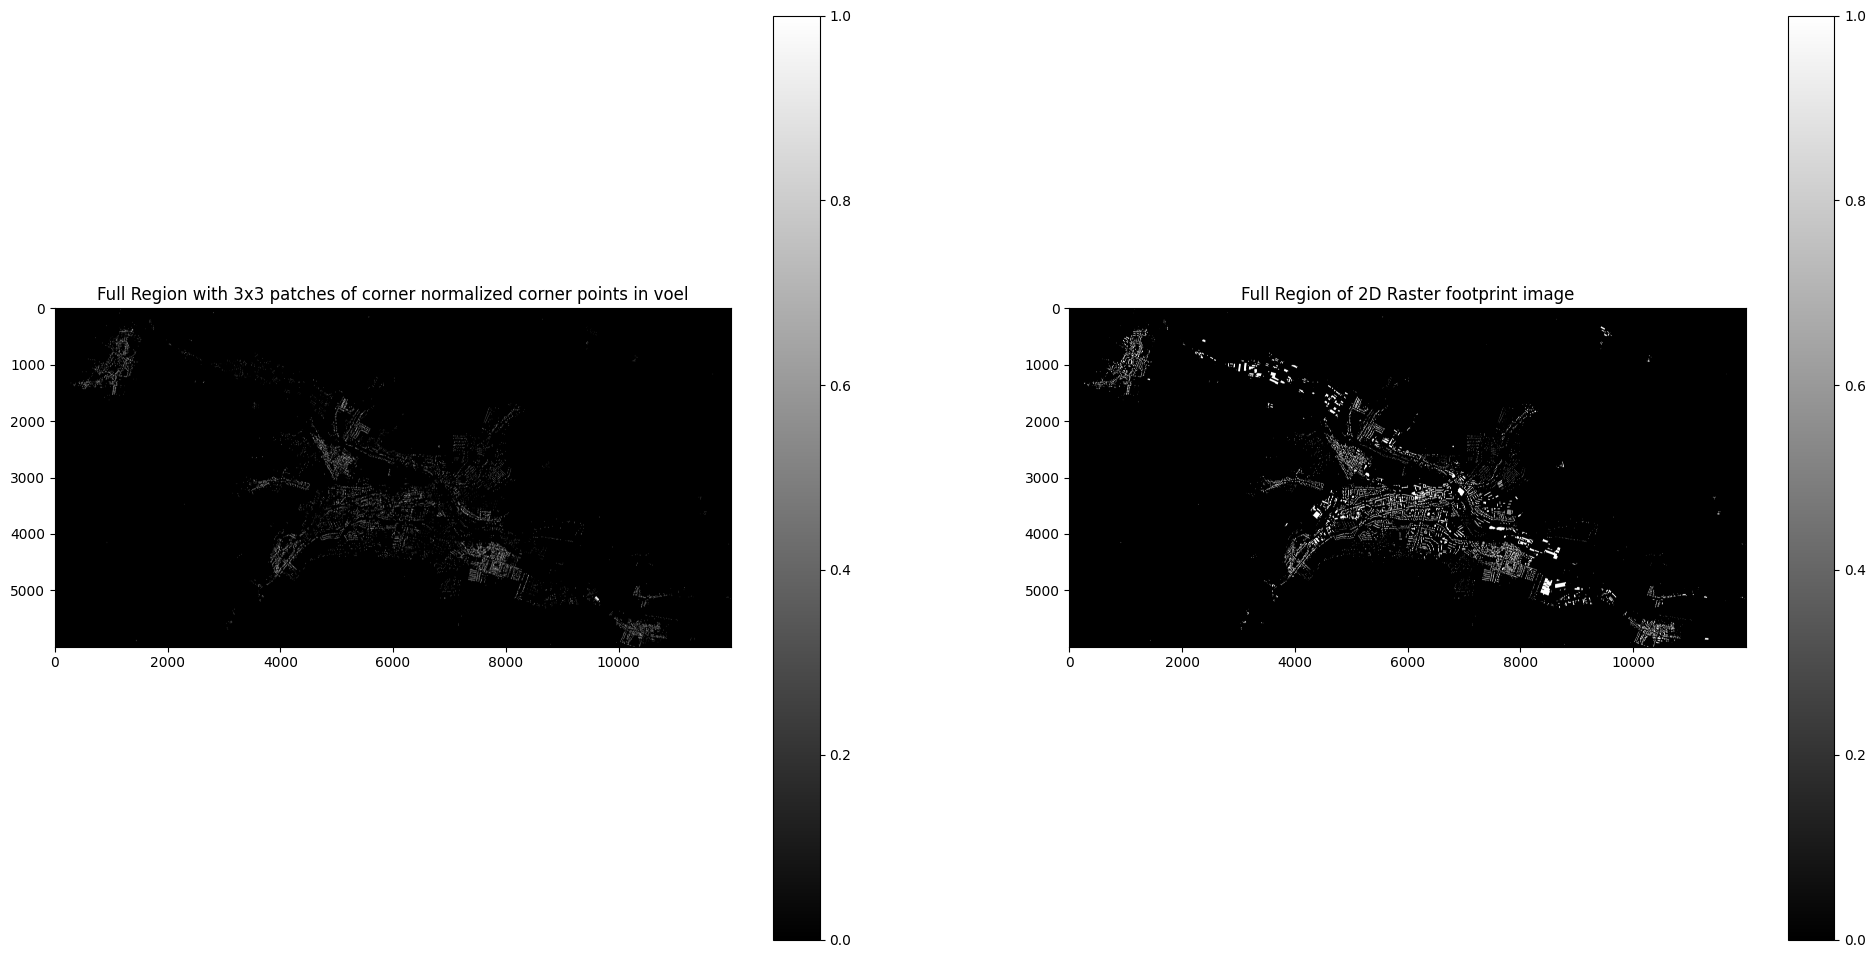

In [8]:
import numpy as np
import matplotlib.pyplot as plt


# Only visualize first z=1 layer
layer = voxel[:, :, 0]

fig, axs = plt.subplots(1, 2, figsize=(24, 12))  # 1 satır, 2 sütun

# Voxel z=0 visualization
im1 = axs[0].imshow(layer, cmap='gray')
axs[0].set_title('Full Region with 3x3 patches of corner normalized corner points in voel')
fig.colorbar(im1, ax=axs[0])

# Second visualization for loaded raster footprint image (image_arr)
im2 = axs[1].imshow(image_arr, cmap='gray')
axs[1].set_title('Full Region of 2D Raster footprint image')
fig.colorbar(im2, ax=axs[1])

plt.show()


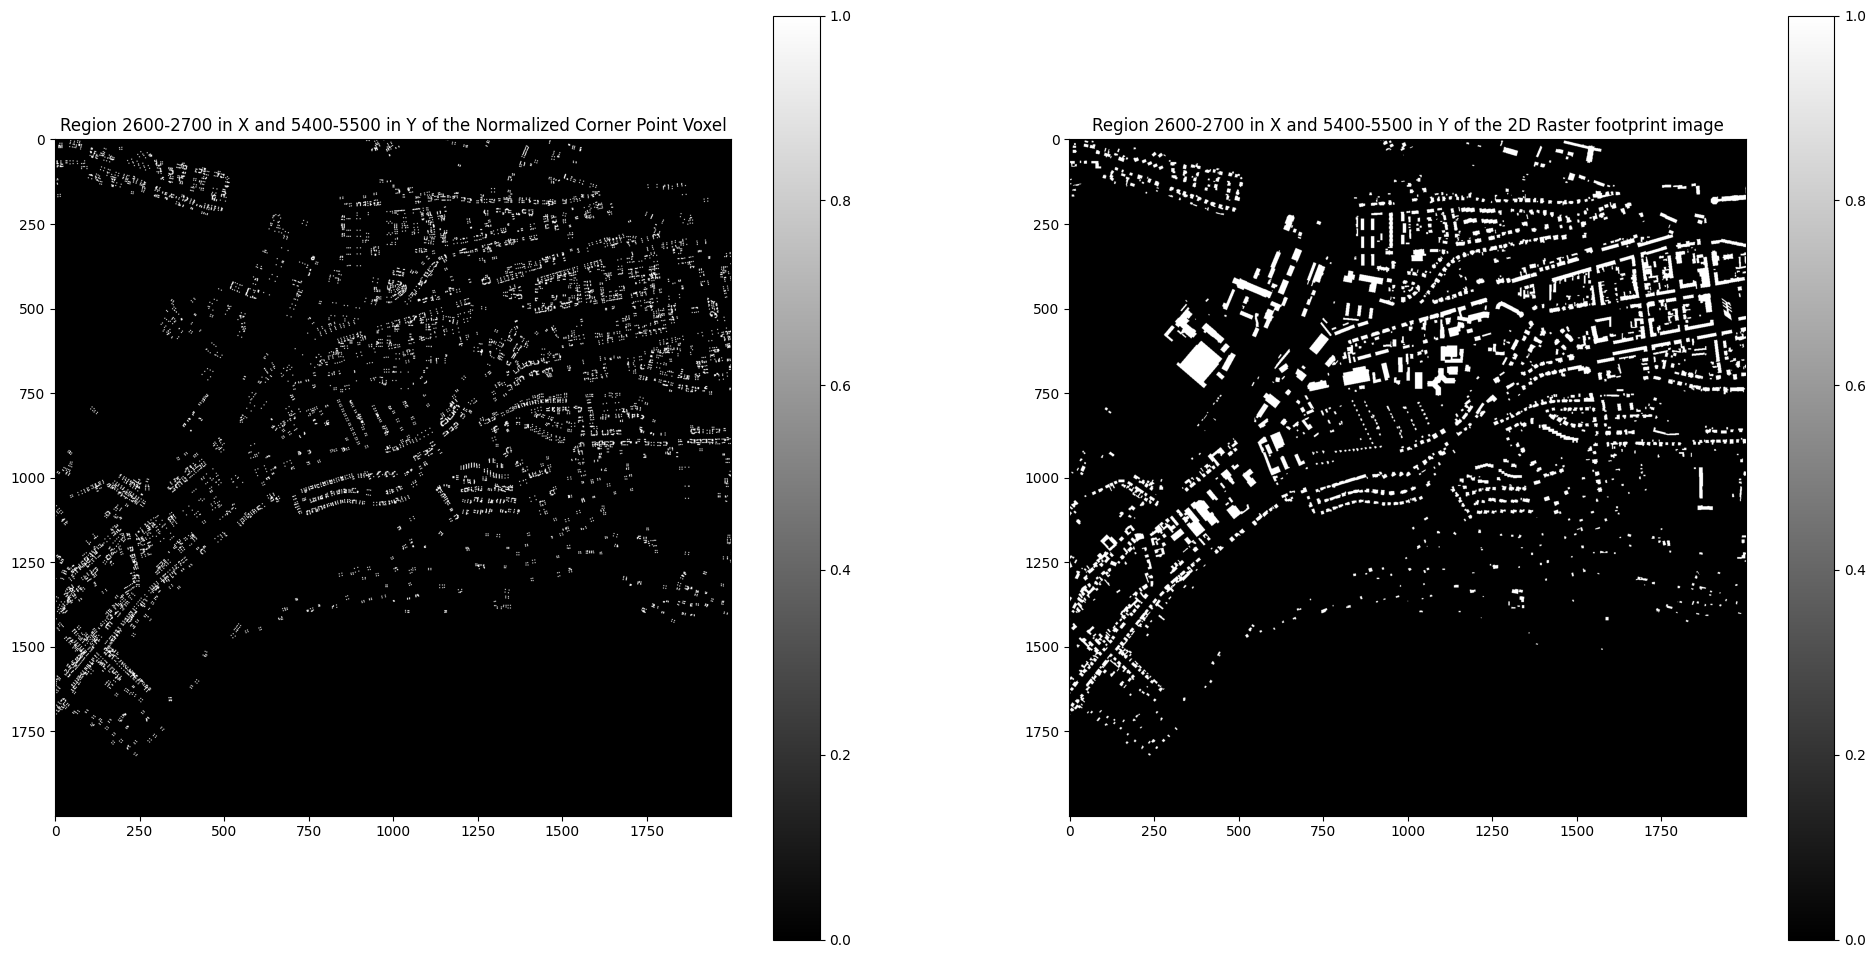

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation

# Örnek bir voxel verisi oluşturuyorum

# İlk görselleştirme
layer = voxel[:, :, 0]

# Focus on more specific regions in the visualization
x_start, x_end = 4000, 6000
y_start, y_end = 3000, 5000
region_of_interest_1 = layer[y_start:y_end, x_start:x_end]
# Focus on more specific regions in the visualization
region_of_interest_2 = image_arr[y_start:y_end, x_start:x_end]

# Yan yana görselleştirme
fig, axs = plt.subplots(1, 2, figsize=(24, 12))  # 1 satır, 2 sütun

im1 = axs[0].imshow(region_of_interest_1, cmap='gray')
axs[0].set_title('Region 2600-2700 in X and 5400-5500 in Y of the Normalized Corner Point Voxel')
fig.colorbar(im1, ax=axs[0])

im2 = axs[1].imshow(region_of_interest_2, cmap='gray')
axs[1].set_title('Region 2600-2700 in X and 5400-5500 in Y of the 2D Raster footprint image')
fig.colorbar(im2, ax=axs[1])

plt.show()



# Total number of closed features (buildings given below here)

In [10]:
labeled_image, num_features = label(image_arr > 0.5)
print("total number of buildings", num_features)

total number of buildings 8454


# CHECK THE INTERSECTION OF BULDING FOOTPRINTS WITH ANY OF THE CORNER POINTS FROM VOXEL. IF ONE OR MORE PIXEL IS MATCHED WITH THE FOOTPRINT, CREATES ANOTHER VOXEL WITH THE HEIGHT OF OF HIGHEST CORNER POINT AND FOOTPRINT OF THE VOXEL 

In [11]:
import numpy as np
from PIL import Image
from scipy.ndimage import label
import time

def assign_height_to_footprint(voxel, image_path):
    start_time = time.time()
    counter = 0
    
    image = Image.open(image_path).convert("L")
    image_arr = np.array(image)
    
    # A new voxel for created result
    result_voxel = np.zeros_like(voxel)

    # Label the buildings
    labeled_image, num_features = label(image_arr > 0.5)
    
    # Find the maximum height values for each label
    max_heights = np.zeros((num_features + 1,), dtype=int)
    indices = np.nonzero(voxel[:, :, 0])
    labels = labeled_image[indices]
    heights = np.sum(voxel[indices[0], indices[1], :], axis=1)
    
    np.maximum.at(max_heights, labels, heights)

    # Assign the height values to buildings
    for label_val in range(1, num_features + 1):
        height = max_heights[label_val]
        if height > 0:
            mask = (labeled_image == label_val)
            result_voxel[mask, :height] = 1
            counter = counter + 1
            if counter % 100 == 0:
                print(counter)
                
    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"Total number of identified footprints: {num_features}")
    print(f"Number of footprints matched with height values: {np.count_nonzero(max_heights > 0)}")
    print(f"Elapsed time: {elapsed_time:.2f} seconds")

    return result_voxel

# File Paths
voxel_path = 'C:/Users/bb26k/Desktop/all_sondershausen_1m_resolution.npy'
image_path = 'C:/Users/bb26k/Desktop/source_1m_sondershausen.tif'

# Load voxel
voxel = np.load(voxel_path)

# Call the function
result_voxel = assign_height_to_footprint(voxel, image_path)

# Save the result
np.save('result_voxel_patches3x3_sondershausen.npy', result_voxel)


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
Total number of identified footprints: 8454
Number of footprints matched with height values: 7803
Elapsed time: 1382.93 seconds


# VISUALIZATION OF THE LATEST CREATED VOXEL

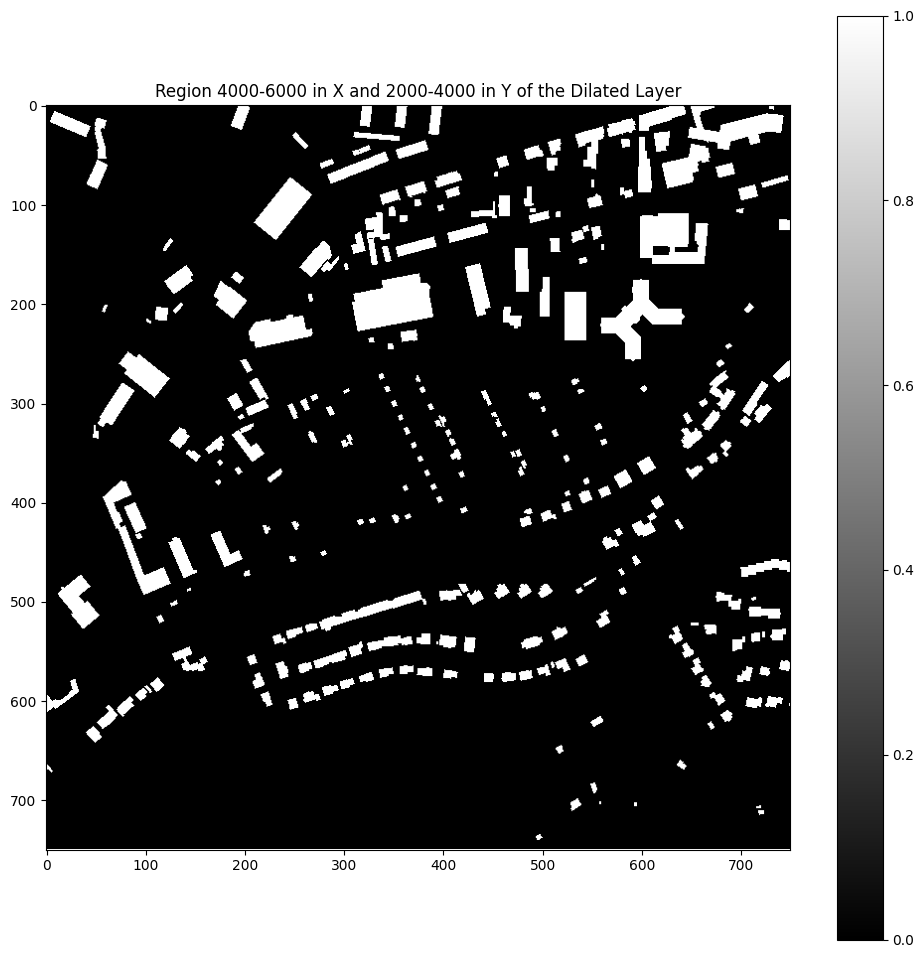

In [12]:
# Load the voxel data
voxel = np.load('result_voxel_patches3x3_sondershausen.npy')

# Select a specific layer (z=0)
layer = voxel[:, :, 0]

# Specify the region of interest
x_start, x_end = 4500, 5250
y_start, y_end = 3500, 4250
region_of_interest = layer[y_start:y_end, x_start:x_end]

# Visualize the specified region
plt.figure(figsize=(12, 12))  # Set figure size to 12x12 inches
plt.imshow(region_of_interest, cmap='gray')
plt.title('Region 4000-6000 in X and 2000-4000 in Y of the Dilated Layer')
plt.colorbar()  # Add color bar
plt.show()


# THE ORGINAL 2D RASTER FOOTPRINT IMAGE OF THE SAME REGION FOR COMPARISON

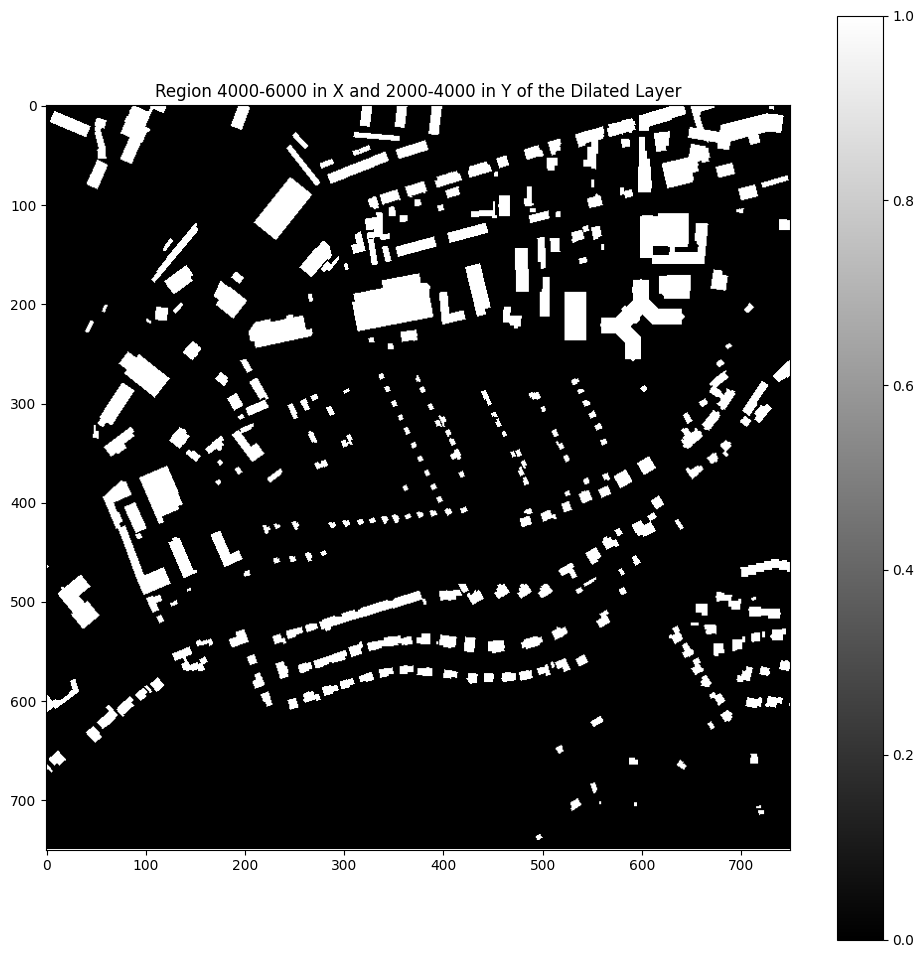

In [13]:

x_start, x_end = 4500, 5250
y_start, y_end = 3500, 4250
region_of_interest = image_arr[y_start:y_end, x_start:x_end]

# Visualize the specified region
plt.figure(figsize=(12, 12))  # Set figure size to 12x12 inches
plt.imshow(region_of_interest, cmap='gray')
plt.title('Region 4000-6000 in X and 2000-4000 in Y of the Dilated Layer')
plt.colorbar()  # Add color bar
plt.show()

# MAPING VOXEL TO 2D LOW RESOLUTION BULDING VOLUME DATA

[[  37272  322345   79550   49387       0     392       0       0     273
    29152    4778       0]
 [ 169699  167991   18497  637007  268862  113611    1433   11280   21775
        0       0     120]
 [      0       0       0    3501  361180  618978  248559  104615   13473
        0       0       0]
 [      0       0     325  106114  526607 1301501 1716685  761219   13059
     2769       0    8123]
 [    468       0       0  215891  374749   76908  522397 1000440 1209859
    34101   13566     618]
 [      0     354       0   24085       0       0    2019    1948  207770
   134611  553428   28480]]


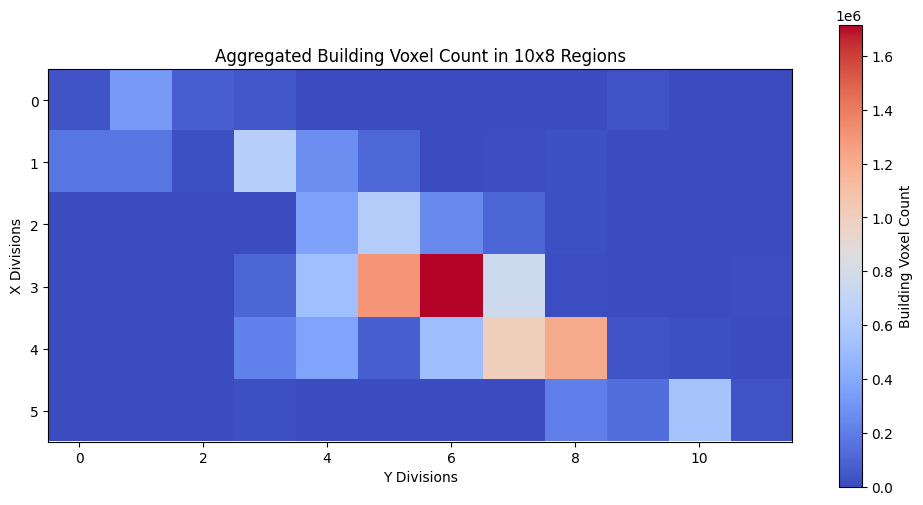

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def aggregate_building_voxels(voxel, x_div, y_div):
    # Get dimensions of the input voxel array
    x_size, y_size, z_size = voxel.shape
    
    # Determine the size of each region
    x_step = x_size // x_div
    y_step = y_size // y_div
    
    # Initialize the result array
    aggregated_voxel = np.zeros((x_div, y_div), dtype=int)
    
    # Aggregate building voxel counts in each region
    for i in range(x_div):
        for j in range(y_div):
            x_start = i * x_step
            x_end = (i + 1) * x_step
            y_start = j * y_step
            y_end = (j + 1) * y_step
            
            region = voxel[x_start:x_end, y_start:y_end, :]
            aggregated_voxel[i, j] = np.sum(region == 1)
    
    return aggregated_voxel
    

# Voxel dosyasını yükle
voxel_path = 'C:/Users/bb26k/Desktop/result_voxel_patches3x3_sondershausen.npy'
voxel = np.load(voxel_path)

# 8x10'luk bölgelere ayır ve her bölgedeki toplam building voxel sayısını hesapla
x_div, y_div = 6, 12
aggregated_voxel = aggregate_building_voxels(voxel, x_div, y_div)
print(aggregated_voxel)
np.save('sondershausen_building_volume.npy', aggregated_voxel)

# Sonuçları coolwarm renk skalasında görselleştir
plt.figure(figsize=(12, 6))
plt.imshow(aggregated_voxel, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Building Voxel Count')
plt.title('Aggregated Building Voxel Count in 10x8 Regions')
plt.xlabel('Y Divisions')
plt.ylabel('X Divisions')
plt.show()


# COORDINATE CONVERTER

In [8]:
from pyproj import Transformer

transformer = Transformer.from_crs("EPSG:25832", "EPSG:4326")

# Not exactly the boundary. If exact boundary is used, it becomes 7x10
x, y = 624000, 5690000
x2, y2 = 636000, 5696000

# Dönüşüm işlemi
lat, lon = transformer.transform(x, y)
lat2, lon2 = transformer.transform(x2, y2)

print(f"lat_min: {lat}, lon_min: {lon}")
print(f"lat_max: {lat2}, lon_max: {lon2}")

lat_min: 51.34773142403504, lon_min: 10.780551457353344
lat_max: 51.39890673773398, lon_max: 10.955056127241454


Differences between min-max lat-lon from the data and actual boundary lat lon  (lat, lon):
Min Lat difference: -0.001668142615351087, Max Lat difference: 0.0018081964742151513
Min Lon difference: 0.00015118116926160496, Max Lon difference: 0.010255750349363879


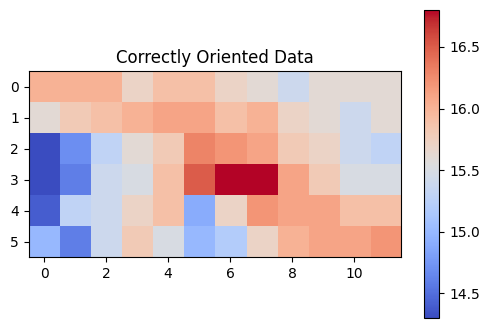

In [10]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Dosya yolunu belirle
file_name = 'C:/Users/bb26k/Desktop/tas_1hr_HOSTRADA-v1-0_BE_gn_2021070100-2021073123.nc'

# Veriyi yükle
data = xr.open_dataset(file_name)
data.load()

# Koordinat aralıklarını belirle
lat_baslangic, lat_bitis = 51.34753142403504, 51.39890673773398 #51.3477 to 51.3475
lon_baslangic, lon_bitis = 10.779551457353344, 10.955056127241454 #10.789 to 10.779

# Maskeleri oluştur
lat_mask = (data["lat"] >= lat_baslangic) & (data["lat"] <= lat_bitis)
lon_mask = (data["lon"] >= lon_baslangic) & (data["lon"] <= lon_bitis)
combined_mask = lat_mask & lon_mask

# Sıcaklık verisini kırp
temperature_crop = data["tas"].where(combined_mask, drop=True)

# Kırpma işlemi sonucunun boş olup olmadığını kontrol et
if temperature_crop.size == 0:
    raise ValueError("The cropped data array is empty. Please check your masking conditions.")

# Belirli bir zaman diliminde sıcaklık verisini seç ve flip et
temperature_time1 = temperature_crop.sel(time=np.datetime64('2021-07-07T01:00:00'))
temperature_time1_flipped = np.flipud(temperature_time1)

# Koordinatları al
latitudes = temperature_crop["lat"].values
longitudes = temperature_crop["lon"].values

# Minimum ve maksimum lat/lon değerlerini belirle
min_lat, max_lat = np.min(latitudes), np.max(latitudes)
min_lon, max_lon = np.min(longitudes), np.max(longitudes)

# Minimum ve maksimum lat/lon değerlerini yazdır
print("Differences between min-max lat-lon from the data and actual boundary lat lon  (lat, lon):")
print(f"Min Lat difference: {lat - min_lat}, Max Lat difference: {lat2- max_lat}")
print(f"Min Lon difference: {lon - min_lon}, Max Lon difference: {lon2 - max_lon}")

# Görselleştirme
plt.figure(figsize=(6, 4))
plt.imshow(temperature_time1_flipped, cmap='coolwarm')
plt.colorbar()
plt.title('Correctly Oriented Data')
plt.show()



# JULY, MONTHLY AVERAGE AT 01:00 AM. (2021)

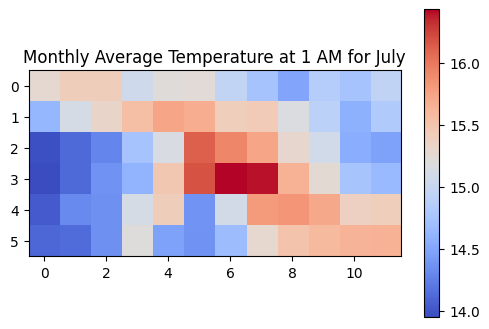

In [12]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Dosya yolunu belirle
file_name = 'C:/Users/bb26k/Desktop/tas_1hr_HOSTRADA-v1-0_BE_gn_2021070100-2021073123.nc'

# Veriyi yükle
data = xr.open_dataset(file_name)
data.load()

# Koordinat aralıklarını belirle
lat_baslangic, lat_bitis = 51.34753142403504, 51.39890673773398 #51.3477 to 51.3475
lon_baslangic, lon_bitis = 10.779551457353344, 10.955056127241454 #10.789 to 10.779

# Maskeleri oluştur
lat_mask = (data["lat"] >= lat_baslangic) & (data["lat"] <= lat_bitis)
lon_mask = (data["lon"] >= lon_baslangic) & (data["lon"] <= lon_bitis)
combined_mask = lat_mask & lon_mask

# Sıcaklık verisini kırp
temperature_crop = data["tas"].where(combined_mask, drop=True)

# Gece 01:00'deki verileri seç
temperature_at_1AM = temperature_crop.sel(time=temperature_crop.time.dt.hour == 1)

# Aylık ortalama hesapla
monthly_average_temp = temperature_at_1AM.groupby("time.month").mean()

# Aylık ortalamadan bir örnek seç (örneğin Temmuz ayı)
example_monthly_average = monthly_average_temp.sel(month=7)

numpy_array = np.flipud(example_monthly_average.values)
np.save('sondershausen_july_temp.npy', numpy_array)  # Kaydet

# Görselleştirme
plt.figure(figsize=(6, 4))
plt.imshow(np.flipud(example_monthly_average.squeeze()), cmap='coolwarm')  # Veriyi y-ekseni boyunca flip et
plt.colorbar()
plt.title('Monthly Average Temperature at 1 AM for July')
plt.show()